In [1]:
import sage
from sklearn.model_selection import train_test_split


# Load data
df = sage.datasets.credit()

# Feature names and categorical columns (for CatBoost model)
feature_names = df.columns.tolist()[:-1]
categorical_columns = [
    'Checking Status', 'Credit History', 'Purpose', 'Credit Amount',
    'Savings Account/Bonds', 'Employment Since', 'Personal Status',
    'Debtors/Guarantors', 'Property Type', 'Other Installment Plans',
    'Housing Ownership', 'Job', 'Telephone', 'Foreign Worker'
]
categorical_inds = [feature_names.index(col) for col in categorical_columns]

# Split data
train, test = train_test_split(
    df.values, test_size=int(0.1 * len(df.values)), random_state=0)
train, val = train_test_split(
    train, test_size=int(0.1 * len(df.values)), random_state=0)
Y_train = train[:, -1].copy().astype(int)
Y_val = val[:, -1].copy().astype(int)
Y_test = test[:, -1].copy().astype(int)
train = train[:, :-1].copy()
val = val[:, :-1].copy()
test = test[:, :-1].copy()

In [2]:
import os

from catboost import CatBoostClassifier


model_filename = "../credit_model.cbm"

if os.path.isfile(model_filename):
    model = CatBoostClassifier()
    model.load_model(model_filename)
else:
    model = CatBoostClassifier(iterations=50, learning_rate=0.3, depth=3)
    model = model.fit(train, Y_train, categorical_inds, eval_set=(val, Y_val), verbose=False)
    model.save_model(model_filename)

In [3]:
import numpy as np
from sklearn.metrics import log_loss


# Calculate performance
p = np.array([np.sum(Y_train == i) for i in np.unique(Y_train)]) / len(Y_train)
base_ce = log_loss(Y_test.astype(int), p[np.newaxis].repeat(len(test), 0))
ce = log_loss(Y_test.astype(int), model.predict_proba(test))

print('Base rate cross entropy = {:.3f}'.format(base_ce))
print('Model cross entropy = {:.3f}'.format(ce))

Base rate cross entropy = 0.602
Model cross entropy = 0.457


In [4]:
from sklearn.metrics import roc_auc_score

print("ROC AUC Score = {:.3f}".format(roc_auc_score(Y_test, model.predict_proba(test)[:, 1])))

ROC AUC Score = 0.849


In [5]:
from sklearn.metrics import confusion_matrix

pred_test = model.predict_proba(test)
pred_test = np.argmax(pred_test, axis=1)

tn, fp, fn, tp = confusion_matrix(Y_test, pred_test, labels=[0,1]).ravel()
p = tp + fn
fnr = fn / p if p > 0.0 else np.float64(0.0)

print("False negative rate = {:.3f}".format(fnr))

False negative rate = 0.042


In [6]:
print("Classifier got {} positive examples wrong".format(int(round(Y_test.sum() * fnr))))

Classifier got 3 positive examples wrong


# Global FNR

In [7]:
# Setup and calculate with custom fairness-related loss function
imputer = sage.MarginalImputer(model, train[:512])
estimator_fnr = sage.PermutationEstimator(imputer, 'fnr')
%time sage_values_fnr = estimator_fnr(test, Y_test, verbose=True, n_permutations=51200)

# Print results
print("SAGE values using false negative rate as loss:", sage_values_fnr)

  0%|          | 0/1 [00:00<?, ?it/s]

fn = 0, p = 352, fnr = 0.0
===> Iteration 0, Prev loss = 0.0 [outer loop]
fn = 0, p = 352, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 352, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 352, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 352, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 352, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 352, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 352, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 352, fnr = 0.005681818181818182
	Loss = 0.005681818181818182 [inner loop]
fn = 2, p = 352, fnr = 0.005681818181818182
	Loss = 0.005681818181818182 [inner loop]
fn = 2, p = 352, fnr = 0.005681818181818182
	Loss = 0.005681818181818182 [inner loop]
fn = 5, p = 352, fnr = 0.014204545454545454
	Loss = 0.014204545454545454 [inner loop]
fn = 5, p = 352, fnr = 0.014204545454545454
	Loss = 0.014204545454545454 [inner loop]
fn = 7, p = 352, fnr = 0.019886363636363636
	Loss = 0.019886363636363636 [inner loop]
fn = 8, p = 352, fnr = 0.022727272727272728
	L

fn = 16, p = 376, fnr = 0.0425531914893617
	Loss = 0.0425531914893617 [inner loop]
fn = 18, p = 376, fnr = 0.047872340425531915
	Loss = 0.047872340425531915 [inner loop]
fn = 20, p = 376, fnr = 0.05319148936170213
	Loss = 0.05319148936170213 [inner loop]
StdDev Ratio = 0.2376 (Converge at 0.0250)
fn = 0, p = 351, fnr = 0.0
===> Iteration 5, Prev loss = 0.0 [outer loop]
fn = 0, p = 351, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 351, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 351, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 351, fnr = 0.002849002849002849
	Loss = 0.002849002849002849 [inner loop]
fn = 2, p = 351, fnr = 0.005698005698005698
	Loss = 0.005698005698005698 [inner loop]
fn = 3, p = 351, fnr = 0.008547008547008548
	Loss = 0.008547008547008548 [inner loop]
fn = 3, p = 351, fnr = 0.008547008547008548
	Loss = 0.008547008547008548 [inner loop]
fn = 4, p = 351, fnr = 0.011396011396011397
	Loss = 0.011396011396011397 [inner loop]
fn = 3, p = 351, fnr = 0.00854700854700854

fn = 11, p = 365, fnr = 0.030136986301369864
	Loss = 0.030136986301369864 [inner loop]
fn = 13, p = 365, fnr = 0.03561643835616438
	Loss = 0.03561643835616438 [inner loop]
fn = 13, p = 365, fnr = 0.03561643835616438
	Loss = 0.03561643835616438 [inner loop]
fn = 18, p = 365, fnr = 0.049315068493150684
	Loss = 0.049315068493150684 [inner loop]
fn = 17, p = 365, fnr = 0.04657534246575343
	Loss = 0.04657534246575343 [inner loop]
fn = 12, p = 365, fnr = 0.03287671232876712
	Loss = 0.03287671232876712 [inner loop]
StdDev Ratio = 0.2788 (Converge at 0.0250)
fn = 0, p = 370, fnr = 0.0
===> Iteration 10, Prev loss = 0.0 [outer loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn =

fn = 10, p = 354, fnr = 0.02824858757062147
	Loss = 0.02824858757062147 [inner loop]
fn = 9, p = 354, fnr = 0.025423728813559324
	Loss = 0.025423728813559324 [inner loop]
fn = 12, p = 354, fnr = 0.03389830508474576
	Loss = 0.03389830508474576 [inner loop]
fn = 17, p = 354, fnr = 0.0480225988700565
	Loss = 0.0480225988700565 [inner loop]
fn = 17, p = 354, fnr = 0.0480225988700565
	Loss = 0.0480225988700565 [inner loop]
fn = 19, p = 354, fnr = 0.05367231638418079
	Loss = 0.05367231638418079 [inner loop]
fn = 21, p = 354, fnr = 0.059322033898305086
	Loss = 0.059322033898305086 [inner loop]
fn = 21, p = 354, fnr = 0.059322033898305086
	Loss = 0.059322033898305086 [inner loop]
fn = 22, p = 354, fnr = 0.062146892655367235
	Loss = 0.062146892655367235 [inner loop]
fn = 17, p = 354, fnr = 0.0480225988700565
	Loss = 0.0480225988700565 [inner loop]
StdDev Ratio = 0.2641 (Converge at 0.0250)
fn = 0, p = 362, fnr = 0.0
===> Iteration 15, Prev loss = 0.0 [outer loop]
fn = 0, p = 362, fnr = 0.0
	Los

fn = 2, p = 353, fnr = 0.0056657223796034
	Loss = 0.0056657223796034 [inner loop]
fn = 3, p = 353, fnr = 0.0084985835694051
	Loss = 0.0084985835694051 [inner loop]
fn = 5, p = 353, fnr = 0.014164305949008499
	Loss = 0.014164305949008499 [inner loop]
fn = 6, p = 353, fnr = 0.0169971671388102
	Loss = 0.0169971671388102 [inner loop]
fn = 6, p = 353, fnr = 0.0169971671388102
	Loss = 0.0169971671388102 [inner loop]
fn = 7, p = 353, fnr = 0.019830028328611898
	Loss = 0.019830028328611898 [inner loop]
fn = 8, p = 353, fnr = 0.0226628895184136
	Loss = 0.0226628895184136 [inner loop]
fn = 9, p = 353, fnr = 0.025495750708215296
	Loss = 0.025495750708215296 [inner loop]
fn = 11, p = 353, fnr = 0.031161473087818695
	Loss = 0.031161473087818695 [inner loop]
fn = 10, p = 353, fnr = 0.028328611898016998
	Loss = 0.028328611898016998 [inner loop]
fn = 11, p = 353, fnr = 0.031161473087818695
	Loss = 0.031161473087818695 [inner loop]
fn = 15, p = 353, fnr = 0.042492917847025496
	Loss = 0.0424929178470254

fn = 0, p = 362, fnr = 0.0
===> Iteration 24, Prev loss = 0.0 [outer loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 362, fnr = 0.0027624309392265192
	Loss = 0.0027624309392265192 [inner loop]
fn = 2, p = 362, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 2, p = 362, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 2, p = 362, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 2, p = 362, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 3, p = 362, fnr = 0.008287292817679558
	Loss = 0.008287292817679558 [inner loop]
fn = 3, p = 362, fnr = 0.008287292817679558
	Loss = 0.008287292817679558 [inner loop]
fn = 2, p = 362, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 3, p = 362, fnr = 0.008287292817679558
	Loss = 0.008287292817679558 [inner loop]
fn = 5, p = 362, fnr = 0.0138121546

fn = 10, p = 370, fnr = 0.02702702702702703
	Loss = 0.02702702702702703 [inner loop]
fn = 10, p = 370, fnr = 0.02702702702702703
	Loss = 0.02702702702702703 [inner loop]
fn = 15, p = 370, fnr = 0.04054054054054054
	Loss = 0.04054054054054054 [inner loop]
fn = 16, p = 370, fnr = 0.043243243243243246
	Loss = 0.043243243243243246 [inner loop]
fn = 13, p = 370, fnr = 0.03513513513513514
	Loss = 0.03513513513513514 [inner loop]
StdDev Ratio = 0.2126 (Converge at 0.0250)
fn = 0, p = 365, fnr = 0.0
===> Iteration 29, Prev loss = 0.0 [outer loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 365, fnr = 0.0027397260273972603
	Loss = 0.0027397260273972603 [inner loop]
fn = 2, p = 365, fnr = 0.005479452054794521
	Loss = 0.005479452054794521 [inner loop]
fn = 3, p = 365, fnr = 0.00821917808219178
	Loss = 0.00821917808219178 [inner loop]
fn = 4, p = 365, fnr = 0.0109589041095890

fn = 11, p = 360, fnr = 0.030555555555555555
	Loss = 0.030555555555555555 [inner loop]
fn = 9, p = 360, fnr = 0.025
	Loss = 0.025 [inner loop]
fn = 12, p = 360, fnr = 0.03333333333333333
	Loss = 0.03333333333333333 [inner loop]
fn = 13, p = 360, fnr = 0.03611111111111111
	Loss = 0.03611111111111111 [inner loop]
fn = 11, p = 360, fnr = 0.030555555555555555
	Loss = 0.030555555555555555 [inner loop]
fn = 9, p = 360, fnr = 0.025
	Loss = 0.025 [inner loop]
fn = 11, p = 360, fnr = 0.030555555555555555
	Loss = 0.030555555555555555 [inner loop]
StdDev Ratio = 0.2527 (Converge at 0.0250)
fn = 0, p = 372, fnr = 0.0
===> Iteration 34, Prev loss = 0.0 [outer loop]
fn = 0, p = 372, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 372, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 372, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 372, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 372, fnr = 0.002688172043010753
	Loss = 0.002688172043010753 [inner loop]
fn = 3, p = 372, fnr = 0.008064516129032258
	

fn = 10, p = 373, fnr = 0.02680965147453083
	Loss = 0.02680965147453083 [inner loop]
fn = 10, p = 373, fnr = 0.02680965147453083
	Loss = 0.02680965147453083 [inner loop]
fn = 11, p = 373, fnr = 0.029490616621983913
	Loss = 0.029490616621983913 [inner loop]
fn = 13, p = 373, fnr = 0.03485254691689008
	Loss = 0.03485254691689008 [inner loop]
fn = 16, p = 373, fnr = 0.04289544235924933
	Loss = 0.04289544235924933 [inner loop]
fn = 17, p = 373, fnr = 0.045576407506702415
	Loss = 0.045576407506702415 [inner loop]
fn = 17, p = 373, fnr = 0.045576407506702415
	Loss = 0.045576407506702415 [inner loop]
fn = 19, p = 373, fnr = 0.05093833780160858
	Loss = 0.05093833780160858 [inner loop]
StdDev Ratio = 0.2307 (Converge at 0.0250)
fn = 0, p = 347, fnr = 0.0
===> Iteration 39, Prev loss = 0.0 [outer loop]
fn = 0, p = 347, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 347, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 347, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 347, fnr = 0.0
	Loss = 0.0 [

fn = 4, p = 389, fnr = 0.010282776349614395
	Loss = 0.010282776349614395 [inner loop]
fn = 4, p = 389, fnr = 0.010282776349614395
	Loss = 0.010282776349614395 [inner loop]
fn = 4, p = 389, fnr = 0.010282776349614395
	Loss = 0.010282776349614395 [inner loop]
fn = 4, p = 389, fnr = 0.010282776349614395
	Loss = 0.010282776349614395 [inner loop]
fn = 6, p = 389, fnr = 0.015424164524421594
	Loss = 0.015424164524421594 [inner loop]
fn = 11, p = 389, fnr = 0.028277634961439587
	Loss = 0.028277634961439587 [inner loop]
fn = 12, p = 389, fnr = 0.030848329048843187
	Loss = 0.030848329048843187 [inner loop]
fn = 14, p = 389, fnr = 0.03598971722365039
	Loss = 0.03598971722365039 [inner loop]
fn = 12, p = 389, fnr = 0.030848329048843187
	Loss = 0.030848329048843187 [inner loop]
fn = 12, p = 389, fnr = 0.030848329048843187
	Loss = 0.030848329048843187 [inner loop]
fn = 15, p = 389, fnr = 0.038560411311053984
	Loss = 0.038560411311053984 [inner loop]
fn = 16, p = 389, fnr = 0.04113110539845758
	Loss 

fn = 3, p = 357, fnr = 0.008403361344537815
	Loss = 0.008403361344537815 [inner loop]
fn = 3, p = 357, fnr = 0.008403361344537815
	Loss = 0.008403361344537815 [inner loop]
fn = 4, p = 357, fnr = 0.011204481792717087
	Loss = 0.011204481792717087 [inner loop]
fn = 4, p = 357, fnr = 0.011204481792717087
	Loss = 0.011204481792717087 [inner loop]
fn = 4, p = 357, fnr = 0.011204481792717087
	Loss = 0.011204481792717087 [inner loop]
fn = 6, p = 357, fnr = 0.01680672268907563
	Loss = 0.01680672268907563 [inner loop]
fn = 8, p = 357, fnr = 0.022408963585434174
	Loss = 0.022408963585434174 [inner loop]
fn = 11, p = 357, fnr = 0.03081232492997199
	Loss = 0.03081232492997199 [inner loop]
fn = 9, p = 357, fnr = 0.025210084033613446
	Loss = 0.025210084033613446 [inner loop]
fn = 9, p = 357, fnr = 0.025210084033613446
	Loss = 0.025210084033613446 [inner loop]
fn = 11, p = 357, fnr = 0.03081232492997199
	Loss = 0.03081232492997199 [inner loop]
fn = 12, p = 357, fnr = 0.03361344537815126
	Loss = 0.0336

fn = 0, p = 364, fnr = 0.0
===> Iteration 53, Prev loss = 0.0 [outer loop]
fn = 0, p = 364, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 364, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 364, fnr = 0.005494505494505495
	Loss = 0.005494505494505495 [inner loop]
fn = 2, p = 364, fnr = 0.005494505494505495
	Loss = 0.005494505494505495 [inner loop]
fn = 3, p = 364, fnr = 0.008241758241758242
	Loss = 0.008241758241758242 [inner loop]
fn = 4, p = 364, fnr = 0.01098901098901099
	Loss = 0.01098901098901099 [inner loop]
fn = 5, p = 364, fnr = 0.013736263736263736
	Loss = 0.013736263736263736 [inner loop]
fn = 7, p = 364, fnr = 0.019230769230769232
	Loss = 0.019230769230769232 [inner loop]
fn = 8, p = 364, fnr = 0.02197802197802198
	Loss = 0.02197802197802198 [inner loop]
fn = 8, p = 364, fnr = 0.02197802197802198
	Loss = 0.02197802197802198 [inner loop]
fn = 8, p = 364, fnr = 0.02197802197802198
	Loss = 0.02197802197802198 [inner loop]
fn = 8, p = 364, fnr = 0.02197802197802198
	Loss = 0.02

fn = 20, p = 373, fnr = 0.05361930294906166
	Loss = 0.05361930294906166 [inner loop]
fn = 23, p = 373, fnr = 0.06166219839142091
	Loss = 0.06166219839142091 [inner loop]
fn = 23, p = 373, fnr = 0.06166219839142091
	Loss = 0.06166219839142091 [inner loop]
fn = 20, p = 373, fnr = 0.05361930294906166
	Loss = 0.05361930294906166 [inner loop]
fn = 20, p = 373, fnr = 0.05361930294906166
	Loss = 0.05361930294906166 [inner loop]
StdDev Ratio = 0.3201 (Converge at 0.0250)
fn = 0, p = 357, fnr = 0.0
===> Iteration 58, Prev loss = 0.0 [outer loop]
fn = 0, p = 357, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 357, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 357, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 357, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 357, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 357, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 357, fnr = 0.0028011204481792717
	Loss = 0.0028011204481792717 [inner loop]
fn = 2, p = 357, fnr = 0.0056022408963585435
	Loss = 0.00

fn = 11, p = 367, fnr = 0.02997275204359673
	Loss = 0.02997275204359673 [inner loop]
fn = 13, p = 367, fnr = 0.035422343324250684
	Loss = 0.035422343324250684 [inner loop]
fn = 12, p = 367, fnr = 0.0326975476839237
	Loss = 0.0326975476839237 [inner loop]
fn = 13, p = 367, fnr = 0.035422343324250684
	Loss = 0.035422343324250684 [inner loop]
fn = 14, p = 367, fnr = 0.03814713896457766
	Loss = 0.03814713896457766 [inner loop]
fn = 17, p = 367, fnr = 0.04632152588555858
	Loss = 0.04632152588555858 [inner loop]
fn = 14, p = 367, fnr = 0.03814713896457766
	Loss = 0.03814713896457766 [inner loop]
fn = 11, p = 367, fnr = 0.02997275204359673
	Loss = 0.02997275204359673 [inner loop]
StdDev Ratio = 0.3261 (Converge at 0.0250)
fn = 0, p = 376, fnr = 0.0
===> Iteration 63, Prev loss = 0.0 [outer loop]
fn = 0, p = 376, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 376, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 376, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 376, fnr = 0.0
	Loss = 0.0 [inne

fn = 3, p = 354, fnr = 0.00847457627118644
	Loss = 0.00847457627118644 [inner loop]
fn = 4, p = 354, fnr = 0.011299435028248588
	Loss = 0.011299435028248588 [inner loop]
fn = 4, p = 354, fnr = 0.011299435028248588
	Loss = 0.011299435028248588 [inner loop]
fn = 4, p = 354, fnr = 0.011299435028248588
	Loss = 0.011299435028248588 [inner loop]
fn = 6, p = 354, fnr = 0.01694915254237288
	Loss = 0.01694915254237288 [inner loop]
fn = 7, p = 354, fnr = 0.01977401129943503
	Loss = 0.01977401129943503 [inner loop]
fn = 9, p = 354, fnr = 0.025423728813559324
	Loss = 0.025423728813559324 [inner loop]
fn = 8, p = 354, fnr = 0.022598870056497175
	Loss = 0.022598870056497175 [inner loop]
fn = 11, p = 354, fnr = 0.031073446327683617
	Loss = 0.031073446327683617 [inner loop]
fn = 15, p = 354, fnr = 0.0423728813559322
	Loss = 0.0423728813559322 [inner loop]
fn = 16, p = 354, fnr = 0.04519774011299435
	Loss = 0.04519774011299435 [inner loop]
fn = 11, p = 354, fnr = 0.031073446327683617
	Loss = 0.03107344

fn = 2, p = 357, fnr = 0.0056022408963585435
	Loss = 0.0056022408963585435 [inner loop]
fn = 2, p = 357, fnr = 0.0056022408963585435
	Loss = 0.0056022408963585435 [inner loop]
fn = 5, p = 357, fnr = 0.014005602240896359
	Loss = 0.014005602240896359 [inner loop]
fn = 4, p = 357, fnr = 0.011204481792717087
	Loss = 0.011204481792717087 [inner loop]
fn = 5, p = 357, fnr = 0.014005602240896359
	Loss = 0.014005602240896359 [inner loop]
fn = 6, p = 357, fnr = 0.01680672268907563
	Loss = 0.01680672268907563 [inner loop]
fn = 7, p = 357, fnr = 0.0196078431372549
	Loss = 0.0196078431372549 [inner loop]
fn = 8, p = 357, fnr = 0.022408963585434174
	Loss = 0.022408963585434174 [inner loop]
fn = 9, p = 357, fnr = 0.025210084033613446
	Loss = 0.025210084033613446 [inner loop]
fn = 12, p = 357, fnr = 0.03361344537815126
	Loss = 0.03361344537815126 [inner loop]
fn = 16, p = 357, fnr = 0.04481792717086835
	Loss = 0.04481792717086835 [inner loop]
fn = 16, p = 357, fnr = 0.04481792717086835
	Loss = 0.0448

fn = 0, p = 361, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 361, fnr = 0.002770083102493075
	Loss = 0.002770083102493075 [inner loop]
fn = 1, p = 361, fnr = 0.002770083102493075
	Loss = 0.002770083102493075 [inner loop]
fn = 1, p = 361, fnr = 0.002770083102493075
	Loss = 0.002770083102493075 [inner loop]
fn = 1, p = 361, fnr = 0.002770083102493075
	Loss = 0.002770083102493075 [inner loop]
fn = 4, p = 361, fnr = 0.0110803324099723
	Loss = 0.0110803324099723 [inner loop]
fn = 4, p = 361, fnr = 0.0110803324099723
	Loss = 0.0110803324099723 [inner loop]
fn = 4, p = 361, fnr = 0.0110803324099723
	Loss = 0.0110803324099723 [inner loop]
fn = 5, p = 361, fnr = 0.013850415512465374
	Loss = 0.013850415512465374 [inner loop]
fn = 5, p = 361, fnr = 0.013850415512465374
	Loss = 0.013850415512465374 [inner loop]
fn = 5, p = 361, fnr = 0.013850415512465374
	Loss = 0.013850415512465374 [inner loop]
fn = 6, p = 361, fnr = 0.01662049861495845
	Loss = 0.01662049861495845 [inner loop]
fn = 11, p = 361

fn = 0, p = 364, fnr = 0.0
===> Iteration 82, Prev loss = 0.0 [outer loop]
fn = 0, p = 364, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 364, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 364, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 364, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 364, fnr = 0.0027472527472527475
	Loss = 0.0027472527472527475 [inner loop]
fn = 2, p = 364, fnr = 0.005494505494505495
	Loss = 0.005494505494505495 [inner loop]
fn = 3, p = 364, fnr = 0.008241758241758242
	Loss = 0.008241758241758242 [inner loop]
fn = 3, p = 364, fnr = 0.008241758241758242
	Loss = 0.008241758241758242 [inner loop]
fn = 5, p = 364, fnr = 0.013736263736263736
	Loss = 0.013736263736263736 [inner loop]
fn = 6, p = 364, fnr = 0.016483516483516484
	Loss = 0.016483516483516484 [inner loop]
fn = 8, p = 364, fnr = 0.02197802197802198
	Loss = 0.02197802197802198 [inner loop]
fn = 10, p = 364, fnr = 0.027472527472527472
	Loss = 0.027472527472527472 [inner loop]
fn = 11, p = 364, fnr = 0.03

fn = 12, p = 373, fnr = 0.032171581769437
	Loss = 0.032171581769437 [inner loop]
fn = 11, p = 373, fnr = 0.029490616621983913
	Loss = 0.029490616621983913 [inner loop]
fn = 14, p = 373, fnr = 0.03753351206434316
	Loss = 0.03753351206434316 [inner loop]
fn = 14, p = 373, fnr = 0.03753351206434316
	Loss = 0.03753351206434316 [inner loop]
StdDev Ratio = 0.2881 (Converge at 0.0250)
fn = 0, p = 376, fnr = 0.0
===> Iteration 87, Prev loss = 0.0 [outer loop]
fn = 0, p = 376, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 376, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 376, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 376, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 376, fnr = 0.0026595744680851063
	Loss = 0.0026595744680851063 [inner loop]
fn = 1, p = 376, fnr = 0.0026595744680851063
	Loss = 0.0026595744680851063 [inner loop]
fn = 1, p = 376, fnr = 0.0026595744680851063
	Loss = 0.0026595744680851063 [inner loop]
fn = 2, p = 376, fnr = 0.005319148936170213
	Loss = 0.005319148936170213

fn = 5, p = 358, fnr = 0.013966480446927373
	Loss = 0.013966480446927373 [inner loop]
fn = 7, p = 358, fnr = 0.019553072625698324
	Loss = 0.019553072625698324 [inner loop]
fn = 10, p = 358, fnr = 0.027932960893854747
	Loss = 0.027932960893854747 [inner loop]
fn = 15, p = 358, fnr = 0.04189944134078212
	Loss = 0.04189944134078212 [inner loop]
fn = 15, p = 358, fnr = 0.04189944134078212
	Loss = 0.04189944134078212 [inner loop]
fn = 17, p = 358, fnr = 0.04748603351955307
	Loss = 0.04748603351955307 [inner loop]
fn = 17, p = 358, fnr = 0.04748603351955307
	Loss = 0.04748603351955307 [inner loop]
fn = 17, p = 358, fnr = 0.04748603351955307
	Loss = 0.04748603351955307 [inner loop]
fn = 14, p = 358, fnr = 0.03910614525139665
	Loss = 0.03910614525139665 [inner loop]
StdDev Ratio = 0.3056 (Converge at 0.0250)
fn = 0, p = 360, fnr = 0.0
===> Iteration 92, Prev loss = 0.0 [outer loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p

fn = 7, p = 351, fnr = 0.019943019943019943
	Loss = 0.019943019943019943 [inner loop]
fn = 4, p = 351, fnr = 0.011396011396011397
	Loss = 0.011396011396011397 [inner loop]
fn = 6, p = 351, fnr = 0.017094017094017096
	Loss = 0.017094017094017096 [inner loop]
fn = 9, p = 351, fnr = 0.02564102564102564
	Loss = 0.02564102564102564 [inner loop]
fn = 7, p = 351, fnr = 0.019943019943019943
	Loss = 0.019943019943019943 [inner loop]
fn = 10, p = 351, fnr = 0.02849002849002849
	Loss = 0.02849002849002849 [inner loop]
fn = 13, p = 351, fnr = 0.037037037037037035
	Loss = 0.037037037037037035 [inner loop]
fn = 11, p = 351, fnr = 0.03133903133903134
	Loss = 0.03133903133903134 [inner loop]
fn = 11, p = 351, fnr = 0.03133903133903134
	Loss = 0.03133903133903134 [inner loop]
fn = 11, p = 351, fnr = 0.03133903133903134
	Loss = 0.03133903133903134 [inner loop]
fn = 11, p = 351, fnr = 0.03133903133903134
	Loss = 0.03133903133903134 [inner loop]
fn = 9, p = 351, fnr = 0.02564102564102564
	Loss = 0.0256410

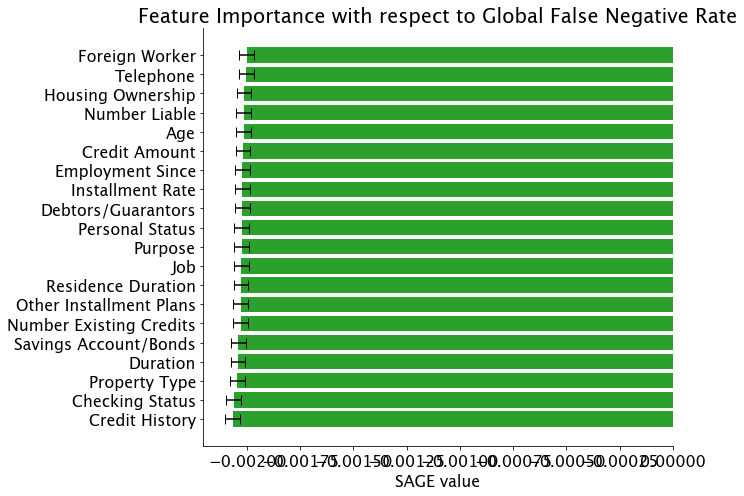

In [8]:
sage_values_fnr.plot(feature_names, title='Feature Importance with respect to Global False Negative Rate')

# Young group FNR

In [9]:
age_col = feature_names.index("Age")

In [10]:
where_young_train = train[:,age_col] <= 30
where_young_test = test[:,age_col] <= 30

test_young = test[where_young_test]
Y_test_young = Y_test[where_young_test]

In [11]:
num_young_train = train[where_young_train].shape[0]
n_permutations_young = num_young_train * 100
print(f"num_young_train = {num_young_train}, n_loops = {int(n_permutations_young / 512)}")

num_young_train = 331, n_loops = 64


In [14]:
# Setup and calculate with custom fairness-related loss function
imputer_young = sage.MarginalImputer(model, train[where_young_train])
estimator_young_fnr = sage.PermutationEstimator(imputer_young, 'fnr')
%time sage_values_young_fnr = estimator_young_fnr(test_young, Y_test_young, verbose=True, \
                                                  batch_size=num_young_train, n_permutations=n_permutations_young)

# Print results
print("SAGE values using false negative rate as loss:", sage_values_young_fnr)

  0%|          | 0/1 [00:00<?, ?it/s]

fn = 0, p = 208, fnr = 0.0
===> Iteration 0, Prev loss = 0.0 [outer loop]
fn = 0, p = 208, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 208, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 208, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 208, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 208, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 208, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 208, fnr = 0.004807692307692308
	Loss = 0.004807692307692308 [inner loop]
fn = 1, p = 208, fnr = 0.004807692307692308
	Loss = 0.004807692307692308 [inner loop]
fn = 1, p = 208, fnr = 0.004807692307692308
	Loss = 0.004807692307692308 [inner loop]
fn = 1, p = 208, fnr = 0.004807692307692308
	Loss = 0.004807692307692308 [inner loop]
fn = 0, p = 208, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 208, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 208, fnr = 0.009615384615384616
	Loss = 0.009615384615384616 [inner loop]
fn = 0, p = 208, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 208, fnr = 0.004

fn = 0, p = 194, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 194, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 194, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 194, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 2, p = 194, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 2, p = 194, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 2, p = 194, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 3, p = 194, fnr = 0.015463917525773196
	Loss = 0.015463917525773196 [inner loop]
fn = 1, p = 194, fnr = 0.005154639175257732
	Loss = 0.005154639175257732 [inner loop]
fn = 0, p = 194, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 194, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 194, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2832 (Converge at 0.0250)
fn = 0, p = 203, fnr = 0.0
===> Iteration 6, Prev loss = 0.0 [outer loop]
fn = 0, p = 203, fnr = 0.0
	Loss = 0.0 [inner loop]
fn 

fn = 2, p = 190, fnr = 0.010526315789473684
	Loss = 0.010526315789473684 [inner loop]
fn = 1, p = 190, fnr = 0.005263157894736842
	Loss = 0.005263157894736842 [inner loop]
fn = 0, p = 190, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 190, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 190, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 190, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 190, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2588 (Converge at 0.0250)
fn = 0, p = 201, fnr = 0.0
===> Iteration 11, Prev loss = 0.0 [outer loop]
fn = 0, p = 201, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 201, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 201, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 201, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 201, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 201, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 201, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 201, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 201, fnr = 0.0
	Loss =

fn = 1, p = 187, fnr = 0.0053475935828877
	Loss = 0.0053475935828877 [inner loop]
fn = 0, p = 187, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 187, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2197 (Converge at 0.0250)
fn = 0, p = 204, fnr = 0.0
===> Iteration 16, Prev loss = 0.0 [outer loop]
fn = 0, p = 204, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 204, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 204, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 204, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 204, fnr = 0.004901960784313725
	Loss = 0.004901960784313725 [inner loop]
fn = 3, p = 204, fnr = 0.014705882352941176
	Loss = 0.014705882352941176 [inner loop]
fn = 4, p = 204, fnr = 0.0196078431372549
	Loss = 0.0196078431372549 [inner loop]
fn = 3, p = 204, fnr = 0.014705882352941176
	Loss = 0.014705882352941176 [inner loop]
fn = 2, p = 204, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 5, p = 204, fnr = 0.024509803921568627
	Loss = 0.0245098039

fn = 0, p = 181, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 181, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 181, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 181, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 181, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 3, p = 181, fnr = 0.016574585635359115
	Loss = 0.016574585635359115 [inner loop]
fn = 1, p = 181, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 1, p = 181, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 1, p = 181, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 2, p = 181, fnr = 0.011049723756906077
	Loss = 0.011049723756906077 [inner loop]
fn = 2, p = 181, fnr = 0.011049723756906077
	Loss = 0.011049723756906077 [inner loop]
fn = 0, p = 181, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2030 (Converge at 0.0250)
fn = 0, p = 193, fnr = 0.0
===> Iteration 22, Prev loss = 0.0 [outer loop]
fn = 0, p = 

fn = 5, p = 203, fnr = 0.024630541871921183
	Loss = 0.024630541871921183 [inner loop]
fn = 4, p = 203, fnr = 0.019704433497536946
	Loss = 0.019704433497536946 [inner loop]
fn = 3, p = 203, fnr = 0.014778325123152709
	Loss = 0.014778325123152709 [inner loop]
fn = 2, p = 203, fnr = 0.009852216748768473
	Loss = 0.009852216748768473 [inner loop]
fn = 0, p = 203, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 203, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2157 (Converge at 0.0250)
fn = 0, p = 197, fnr = 0.0
===> Iteration 27, Prev loss = 0.0 [outer loop]
fn = 0, p = 197, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 197, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 197, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 197, fnr = 0.005076142131979695
	Loss = 0.005076142131979695 [inner loop]
fn = 2, p = 197, fnr = 0.01015228426395939
	Loss = 0.01015228426395939 [inner loop]
fn = 2, p = 197, fnr = 0.01015228426395939
	Loss = 0.01015228426395939 [inner loop]
fn = 1, p = 197, fnr = 0

fn = 0, p = 204, fnr = 0.0
===> Iteration 32, Prev loss = 0.0 [outer loop]
fn = 0, p = 204, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 204, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 204, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 204, fnr = 0.004901960784313725
	Loss = 0.004901960784313725 [inner loop]
fn = 1, p = 204, fnr = 0.004901960784313725
	Loss = 0.004901960784313725 [inner loop]
fn = 1, p = 204, fnr = 0.004901960784313725
	Loss = 0.004901960784313725 [inner loop]
fn = 2, p = 204, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 3, p = 204, fnr = 0.014705882352941176
	Loss = 0.014705882352941176 [inner loop]
fn = 3, p = 204, fnr = 0.014705882352941176
	Loss = 0.014705882352941176 [inner loop]
fn = 3, p = 204, fnr = 0.014705882352941176
	Loss = 0.014705882352941176 [inner loop]
fn = 3, p = 204, fnr = 0.014705882352941176
	Loss = 0.014705882352941176 [inner loop]
fn = 2, p = 204, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]

fn = 3, p = 193, fnr = 0.015544041450777202
	Loss = 0.015544041450777202 [inner loop]
fn = 3, p = 193, fnr = 0.015544041450777202
	Loss = 0.015544041450777202 [inner loop]
fn = 3, p = 193, fnr = 0.015544041450777202
	Loss = 0.015544041450777202 [inner loop]
fn = 2, p = 193, fnr = 0.010362694300518135
	Loss = 0.010362694300518135 [inner loop]
fn = 4, p = 193, fnr = 0.02072538860103627
	Loss = 0.02072538860103627 [inner loop]
fn = 2, p = 193, fnr = 0.010362694300518135
	Loss = 0.010362694300518135 [inner loop]
fn = 2, p = 193, fnr = 0.010362694300518135
	Loss = 0.010362694300518135 [inner loop]
fn = 2, p = 193, fnr = 0.010362694300518135
	Loss = 0.010362694300518135 [inner loop]
fn = 0, p = 193, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 193, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 193, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 193, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 193, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 193, fnr = 0.0
	Loss = 0.0 [inner loop]
St

fn = 0, p = 198, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 198, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1860 (Converge at 0.0250)
fn = 0, p = 203, fnr = 0.0
===> Iteration 43, Prev loss = 0.0 [outer loop]
fn = 0, p = 203, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 203, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 203, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 203, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 203, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 203, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 203, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 203, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 203, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 203, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 203, fnr = 0.0049261083743842365
	Loss = 0.0049261083743842365 [inner loop]
fn = 1, p = 203, fnr = 0.0049261083743842365
	Loss = 0.0049261083743842365 [inner loop]
fn = 2, p = 203, fnr = 0.009852216748768473
	Loss = 0.009852216748768473 [inner lo

fn = 0, p = 185, fnr = 0.0
===> Iteration 48, Prev loss = 0.0 [outer loop]
fn = 0, p = 185, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 185, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 185, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 185, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 185, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 185, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 185, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 185, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 185, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 185, fnr = 0.005405405405405406
	Loss = 0.005405405405405406 [inner loop]
fn = 0, p = 185, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 185, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 185, fnr = 0.010810810810810811
	Loss = 0.010810810810810811 [inner loop]
fn = 2, p = 185, fnr = 0.010810810810810811
	Loss = 0.010810810810810811 [inner loop]
fn = 3, p = 185, fnr = 0.016216216216216217
	Loss = 0.016216216216216217 [inner loop]
fn = 2, p

fn = 3, p = 194, fnr = 0.015463917525773196
	Loss = 0.015463917525773196 [inner loop]
fn = 4, p = 194, fnr = 0.020618556701030927
	Loss = 0.020618556701030927 [inner loop]
fn = 3, p = 194, fnr = 0.015463917525773196
	Loss = 0.015463917525773196 [inner loop]
fn = 4, p = 194, fnr = 0.020618556701030927
	Loss = 0.020618556701030927 [inner loop]
fn = 4, p = 194, fnr = 0.020618556701030927
	Loss = 0.020618556701030927 [inner loop]
fn = 5, p = 194, fnr = 0.02577319587628866
	Loss = 0.02577319587628866 [inner loop]
fn = 4, p = 194, fnr = 0.020618556701030927
	Loss = 0.020618556701030927 [inner loop]
fn = 3, p = 194, fnr = 0.015463917525773196
	Loss = 0.015463917525773196 [inner loop]
fn = 2, p = 194, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 0, p = 194, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 194, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1970 (Converge at 0.0250)
fn = 0, p = 197, fnr = 0.0
===> Iteration 54, Prev loss = 0.0 [outer loop]
fn = 0

fn = 0, p = 177, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1880 (Converge at 0.0250)
fn = 0, p = 181, fnr = 0.0
===> Iteration 59, Prev loss = 0.0 [outer loop]
fn = 0, p = 181, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 181, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 181, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 181, fnr = 0.011049723756906077
	Loss = 0.011049723756906077 [inner loop]
fn = 2, p = 181, fnr = 0.011049723756906077
	Loss = 0.011049723756906077 [inner loop]
fn = 2, p = 181, fnr = 0.011049723756906077
	Loss = 0.011049723756906077 [inner loop]
fn = 1, p = 181, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 1, p = 181, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 1, p = 181, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 2, p = 181, fnr = 0.011049723756906077
	Loss = 0.011049723756906077 [inner loop]
fn = 2, p = 181, fnr = 0.011049723756906077
	Loss = 0.011049723756

fn = 0, p = 186, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 186, fnr = 0.010752688172043012
	Loss = 0.010752688172043012 [inner loop]
fn = 3, p = 186, fnr = 0.016129032258064516
	Loss = 0.016129032258064516 [inner loop]
fn = 1, p = 186, fnr = 0.005376344086021506
	Loss = 0.005376344086021506 [inner loop]
fn = 0, p = 186, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 186, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 186, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1893 (Converge at 0.0250)
fn = 0, p = 202, fnr = 0.0
===> Iteration 65, Prev loss = 0.0 [outer loop]
fn = 0, p = 202, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 202, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 202, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 202, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 202, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 202, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 202, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 202, fnr = 0.0
	Loss = 0.0 [inner loop]


fn = 0, p = 195, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1801 (Converge at 0.0250)
fn = 0, p = 183, fnr = 0.0
===> Iteration 70, Prev loss = 0.0 [outer loop]
fn = 0, p = 183, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 183, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 183, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 183, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 183, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 183, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 183, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 183, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 183, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 183, fnr = 0.00546448087431694
	Loss = 0.00546448087431694 [inner loop]
fn = 1, p = 183, fnr = 0.00546448087431694
	Loss = 0.00546448087431694 [inner loop]
fn = 1, p = 183, fnr = 0.00546448087431694
	Loss = 0.00546448087431694 [inner loop]
fn = 1, p = 183, fnr = 0.00546448087431694
	Loss = 0.00546448087431694 [inner loop]
fn = 2, p = 183, fnr = 0.0

fn = 1, p = 186, fnr = 0.005376344086021506
	Loss = 0.005376344086021506 [inner loop]
fn = 1, p = 186, fnr = 0.005376344086021506
	Loss = 0.005376344086021506 [inner loop]
fn = 1, p = 186, fnr = 0.005376344086021506
	Loss = 0.005376344086021506 [inner loop]
fn = 3, p = 186, fnr = 0.016129032258064516
	Loss = 0.016129032258064516 [inner loop]
fn = 5, p = 186, fnr = 0.026881720430107527
	Loss = 0.026881720430107527 [inner loop]
fn = 6, p = 186, fnr = 0.03225806451612903
	Loss = 0.03225806451612903 [inner loop]
fn = 6, p = 186, fnr = 0.03225806451612903
	Loss = 0.03225806451612903 [inner loop]
fn = 6, p = 186, fnr = 0.03225806451612903
	Loss = 0.03225806451612903 [inner loop]
fn = 5, p = 186, fnr = 0.026881720430107527
	Loss = 0.026881720430107527 [inner loop]
fn = 4, p = 186, fnr = 0.021505376344086023
	Loss = 0.021505376344086023 [inner loop]
fn = 3, p = 186, fnr = 0.016129032258064516
	Loss = 0.016129032258064516 [inner loop]
fn = 2, p = 186, fnr = 0.010752688172043012
	Loss = 0.010752

fn = 3, p = 208, fnr = 0.014423076923076924
	Loss = 0.014423076923076924 [inner loop]
fn = 5, p = 208, fnr = 0.02403846153846154
	Loss = 0.02403846153846154 [inner loop]
fn = 4, p = 208, fnr = 0.019230769230769232
	Loss = 0.019230769230769232 [inner loop]
fn = 3, p = 208, fnr = 0.014423076923076924
	Loss = 0.014423076923076924 [inner loop]
fn = 3, p = 208, fnr = 0.014423076923076924
	Loss = 0.014423076923076924 [inner loop]
fn = 2, p = 208, fnr = 0.009615384615384616
	Loss = 0.009615384615384616 [inner loop]
fn = 2, p = 208, fnr = 0.009615384615384616
	Loss = 0.009615384615384616 [inner loop]
fn = 1, p = 208, fnr = 0.004807692307692308
	Loss = 0.004807692307692308 [inner loop]
fn = 0, p = 208, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1848 (Converge at 0.0250)
fn = 0, p = 199, fnr = 0.0
===> Iteration 81, Prev loss = 0.0 [outer loop]
fn = 0, p = 199, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 199, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 199, fnr = 0.0
	Loss = 0.0 [

fn = 0, p = 195, fnr = 0.0
===> Iteration 86, Prev loss = 0.0 [outer loop]
fn = 0, p = 195, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 195, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 195, fnr = 0.005128205128205128
	Loss = 0.005128205128205128 [inner loop]
fn = 0, p = 195, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 195, fnr = 0.005128205128205128
	Loss = 0.005128205128205128 [inner loop]
fn = 0, p = 195, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 195, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 195, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 195, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 195, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 195, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 195, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 195, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 195, fnr = 0.005128205128205128
	Loss = 0.005128205128205128 [inner loop]
fn = 3, p = 195, fnr = 0.015384615384615385
	Loss = 0.015384615384615385 [inner loop]
fn = 3, p

fn = 1, p = 190, fnr = 0.005263157894736842
	Loss = 0.005263157894736842 [inner loop]
fn = 1, p = 190, fnr = 0.005263157894736842
	Loss = 0.005263157894736842 [inner loop]
fn = 0, p = 190, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 190, fnr = 0.005263157894736842
	Loss = 0.005263157894736842 [inner loop]
fn = 0, p = 190, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 190, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 190, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 190, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1858 (Converge at 0.0250)
fn = 0, p = 190, fnr = 0.0
===> Iteration 92, Prev loss = 0.0 [outer loop]
fn = 0, p = 190, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 190, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 190, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 190, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 190, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 190, fnr = 0.005263157894736842
	Loss = 0.005263157894736842 [inner loop]
fn = 1, p = 190, f

fn = 0, p = 202, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 202, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 202, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 202, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 202, fnr = 0.0049504950495049506
	Loss = 0.0049504950495049506 [inner loop]
fn = 1, p = 202, fnr = 0.0049504950495049506
	Loss = 0.0049504950495049506 [inner loop]
fn = 2, p = 202, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 2, p = 202, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 2, p = 202, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 1, p = 202, fnr = 0.0049504950495049506
	Loss = 0.0049504950495049506 [inner loop]
fn = 1, p = 202, fnr = 0.0049504950495049506
	Loss = 0.0049504950495049506 [inner loop]
fn = 0, p = 202, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 202, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 202, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 202, fnr = 0.0

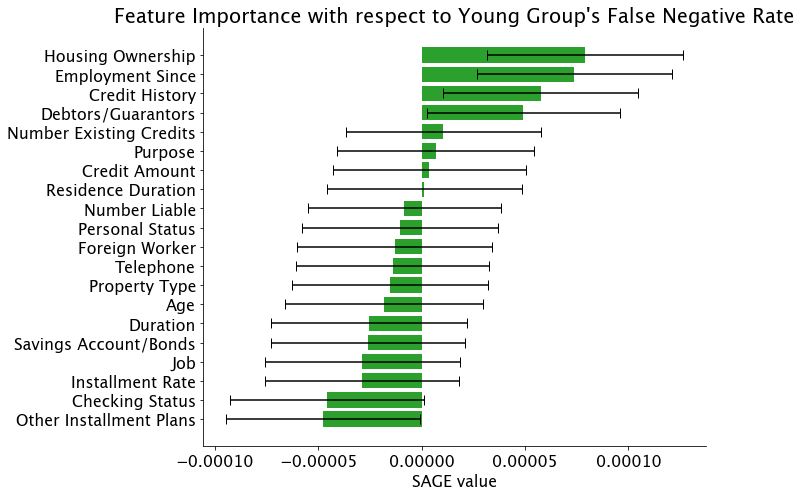

In [15]:
sage_values_young_fnr.plot(feature_names, title='Feature Importance with respect to Young Group\'s False Negative Rate')

# Old group FNR

In [16]:
where_old_train = train[:,age_col] > 30
where_old_test = np.invert(where_young_test)

test_old = test[where_old_test]
Y_test_old = Y_test[where_old_test]

In [17]:
num_old_train = train[where_old_train].shape[0]
n_permutations_old = num_old_train * 100
print(f"num_old_train = {num_old_train}, n_loops = {int(n_permutations_old / 512)}")

num_old_train = 469, n_loops = 91


In [18]:
# Setup and calculate with custom fairness-related loss function
imputer_old = sage.MarginalImputer(model, train[where_old_train])
estimator_old_fnr = sage.PermutationEstimator(imputer_old, 'fnr')
%time sage_values_old_fnr = estimator_old_fnr(test_old, Y_test_old, verbose=True, \
                                              batch_size=num_old_train, n_permutations=n_permutations_old)

# Print results
print("SAGE values using false negative rate as loss:", sage_values_old_fnr)

  0%|          | 0/1 [00:00<?, ?it/s]

fn = 0, p = 368, fnr = 0.0
===> Iteration 0, Prev loss = 0.0 [outer loop]
fn = 0, p = 368, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 368, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 368, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 368, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 368, fnr = 0.002717391304347826
	Loss = 0.002717391304347826 [inner loop]
fn = 3, p = 368, fnr = 0.008152173913043478
	Loss = 0.008152173913043478 [inner loop]
fn = 5, p = 368, fnr = 0.01358695652173913
	Loss = 0.01358695652173913 [inner loop]
fn = 5, p = 368, fnr = 0.01358695652173913
	Loss = 0.01358695652173913 [inner loop]
fn = 4, p = 368, fnr = 0.010869565217391304
	Loss = 0.010869565217391304 [inner loop]
fn = 4, p = 368, fnr = 0.010869565217391304
	Loss = 0.010869565217391304 [inner loop]
fn = 5, p = 368, fnr = 0.01358695652173913
	Loss = 0.01358695652173913 [inner loop]
fn = 10, p = 368, fnr = 0.02717391304347826
	Loss = 0.02717391304347826 [inner loop]
fn = 12, p = 368, fnr = 0.03260869565

fn = 0, p = 370, fnr = 0.0
===> Iteration 5, Prev loss = 0.0 [outer loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 370, fnr = 0.002702702702702703
	Loss = 0.002702702702702703 [inner loop]
fn = 2, p = 370, fnr = 0.005405405405405406
	Loss = 0.005405405405405406 [inner loop]
fn = 3, p = 370, fnr = 0.008108108108108109
	Loss = 0.008108108108108109 [inner loop]
fn = 5, p = 370, fnr = 0.013513513513513514
	Loss = 0.013513513513513514 [inner loop]
fn = 7, p = 370, fnr = 0.01891891891891892
	Loss = 0.01891891891891892 [inner loop]
fn = 6, p = 370, fnr = 0.016216216216216217
	Loss = 0.016216216216216217 [inner loop]
fn = 7, p = 370, fnr = 0.01891891891891892
	Loss = 0.01891891891891892 [inner loop]
fn = 7, p = 370, fnr = 0.01891891891891892
	Loss = 0.01891891891891892 [inner loop]
fn = 12, p = 370, fnr = 0.0324324324

fn = 23, p = 376, fnr = 0.061170212765957445
	Loss = 0.061170212765957445 [inner loop]
fn = 21, p = 376, fnr = 0.05585106382978723
	Loss = 0.05585106382978723 [inner loop]
fn = 19, p = 376, fnr = 0.05053191489361702
	Loss = 0.05053191489361702 [inner loop]
StdDev Ratio = 0.3806 (Converge at 0.0250)
fn = 0, p = 376, fnr = 0.0
===> Iteration 10, Prev loss = 0.0 [outer loop]
fn = 0, p = 376, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 376, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 376, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 376, fnr = 0.0026595744680851063
	Loss = 0.0026595744680851063 [inner loop]
fn = 2, p = 376, fnr = 0.005319148936170213
	Loss = 0.005319148936170213 [inner loop]
fn = 3, p = 376, fnr = 0.007978723404255319
	Loss = 0.007978723404255319 [inner loop]
fn = 3, p = 376, fnr = 0.007978723404255319
	Loss = 0.007978723404255319 [inner loop]
fn = 5, p = 376, fnr = 0.013297872340425532
	Loss = 0.013297872340425532 [inner loop]
fn = 5, p = 376, fnr = 0.013297872340

fn = 14, p = 377, fnr = 0.03713527851458886
	Loss = 0.03713527851458886 [inner loop]
fn = 18, p = 377, fnr = 0.04774535809018567
	Loss = 0.04774535809018567 [inner loop]
fn = 17, p = 377, fnr = 0.04509283819628647
	Loss = 0.04509283819628647 [inner loop]
fn = 17, p = 377, fnr = 0.04509283819628647
	Loss = 0.04509283819628647 [inner loop]
fn = 21, p = 377, fnr = 0.05570291777188329
	Loss = 0.05570291777188329 [inner loop]
fn = 21, p = 377, fnr = 0.05570291777188329
	Loss = 0.05570291777188329 [inner loop]
fn = 24, p = 377, fnr = 0.0636604774535809
	Loss = 0.0636604774535809 [inner loop]
fn = 28, p = 377, fnr = 0.07427055702917772
	Loss = 0.07427055702917772 [inner loop]
StdDev Ratio = 0.2384 (Converge at 0.0250)
fn = 0, p = 359, fnr = 0.0
===> Iteration 15, Prev loss = 0.0 [outer loop]
fn = 0, p = 359, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 359, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 359, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 359, fnr = 0.0
	Loss = 0.0 [inner lo

fn = 14, p = 346, fnr = 0.04046242774566474
	Loss = 0.04046242774566474 [inner loop]
fn = 17, p = 346, fnr = 0.049132947976878616
	Loss = 0.049132947976878616 [inner loop]
fn = 20, p = 346, fnr = 0.057803468208092484
	Loss = 0.057803468208092484 [inner loop]
fn = 21, p = 346, fnr = 0.06069364161849711
	Loss = 0.06069364161849711 [inner loop]
fn = 24, p = 346, fnr = 0.06936416184971098
	Loss = 0.06936416184971098 [inner loop]
fn = 28, p = 346, fnr = 0.08092485549132948
	Loss = 0.08092485549132948 [inner loop]
fn = 30, p = 346, fnr = 0.08670520231213873
	Loss = 0.08670520231213873 [inner loop]
fn = 33, p = 346, fnr = 0.0953757225433526
	Loss = 0.0953757225433526 [inner loop]
fn = 32, p = 346, fnr = 0.09248554913294797
	Loss = 0.09248554913294797 [inner loop]
StdDev Ratio = 0.2292 (Converge at 0.0250)
fn = 0, p = 359, fnr = 0.0
===> Iteration 20, Prev loss = 0.0 [outer loop]
fn = 0, p = 359, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 359, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p =

fn = 3, p = 343, fnr = 0.008746355685131196
	Loss = 0.008746355685131196 [inner loop]
fn = 4, p = 343, fnr = 0.011661807580174927
	Loss = 0.011661807580174927 [inner loop]
fn = 6, p = 343, fnr = 0.01749271137026239
	Loss = 0.01749271137026239 [inner loop]
fn = 9, p = 343, fnr = 0.026239067055393587
	Loss = 0.026239067055393587 [inner loop]
fn = 13, p = 343, fnr = 0.037900874635568516
	Loss = 0.037900874635568516 [inner loop]
fn = 13, p = 343, fnr = 0.037900874635568516
	Loss = 0.037900874635568516 [inner loop]
fn = 14, p = 343, fnr = 0.04081632653061224
	Loss = 0.04081632653061224 [inner loop]
fn = 11, p = 343, fnr = 0.03206997084548105
	Loss = 0.03206997084548105 [inner loop]
fn = 11, p = 343, fnr = 0.03206997084548105
	Loss = 0.03206997084548105 [inner loop]
fn = 11, p = 343, fnr = 0.03206997084548105
	Loss = 0.03206997084548105 [inner loop]
fn = 12, p = 343, fnr = 0.03498542274052478
	Loss = 0.03498542274052478 [inner loop]
fn = 12, p = 343, fnr = 0.03498542274052478
	Loss = 0.03498

fn = 3, p = 369, fnr = 0.008130081300813009
	Loss = 0.008130081300813009 [inner loop]
fn = 5, p = 369, fnr = 0.013550135501355014
	Loss = 0.013550135501355014 [inner loop]
fn = 8, p = 369, fnr = 0.02168021680216802
	Loss = 0.02168021680216802 [inner loop]
fn = 10, p = 369, fnr = 0.02710027100271003
	Loss = 0.02710027100271003 [inner loop]
fn = 9, p = 369, fnr = 0.024390243902439025
	Loss = 0.024390243902439025 [inner loop]
fn = 7, p = 369, fnr = 0.018970189701897018
	Loss = 0.018970189701897018 [inner loop]
fn = 7, p = 369, fnr = 0.018970189701897018
	Loss = 0.018970189701897018 [inner loop]
fn = 9, p = 369, fnr = 0.024390243902439025
	Loss = 0.024390243902439025 [inner loop]
fn = 10, p = 369, fnr = 0.02710027100271003
	Loss = 0.02710027100271003 [inner loop]
fn = 14, p = 369, fnr = 0.037940379403794036
	Loss = 0.037940379403794036 [inner loop]
fn = 15, p = 369, fnr = 0.04065040650406504
	Loss = 0.04065040650406504 [inner loop]
fn = 16, p = 369, fnr = 0.04336043360433604
	Loss = 0.0433

fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 362, fnr = 0.0027624309392265192
	Loss = 0.0027624309392265192 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 362, fnr = 0.0027624309392265192
	Loss = 0.0027624309392265192 [inner loop]
fn = 2, p = 362, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 2, p = 362, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 3, p = 362, fnr = 0.008287292817679558
	Loss = 0.008287292817679558 [inner loop]
fn = 5, p = 362, fnr = 0.013812154696132596
	Loss = 0.013812154696132596 [inner loop]
fn = 9, p = 362, fnr = 0.024861878453038673
	Loss = 0.024861878453038673 [inner loop]
fn = 12, p = 362, fnr = 0.03314917127071823
	Loss = 0.03314917127071823 [inner loop]
fn = 15, p = 362, fnr = 0.04143646408839779
	Loss = 0.04143646408839779 [inner loop]
fn = 18, p = 362, fnr = 0.049723756906077346
	Loss = 0.049723756

fn = 15, p = 379, fnr = 0.0395778364116095
	Loss = 0.0395778364116095 [inner loop]
fn = 18, p = 379, fnr = 0.047493403693931395
	Loss = 0.047493403693931395 [inner loop]
fn = 17, p = 379, fnr = 0.044854881266490766
	Loss = 0.044854881266490766 [inner loop]
fn = 17, p = 379, fnr = 0.044854881266490766
	Loss = 0.044854881266490766 [inner loop]
StdDev Ratio = 0.2252 (Converge at 0.0250)
fn = 0, p = 362, fnr = 0.0
===> Iteration 39, Prev loss = 0.0 [outer loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 362, fnr = 0.0027624309392265192
	Loss = 0.0027624309392265192 [inner loop]
fn = 2, p = 362, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 3, p = 362, fnr = 0.008287292817679558
	Loss = 0.008287292817679558 [inner loop]
fn = 4, p = 362, fnr = 0.011049723756906077
	Loss = 0.011049723756906077 [inner loop]
fn = 3, p = 362, fnr = 0.008287292

fn = 14, p = 381, fnr = 0.03674540682414698
	Loss = 0.03674540682414698 [inner loop]
fn = 19, p = 381, fnr = 0.049868766404199474
	Loss = 0.049868766404199474 [inner loop]
fn = 21, p = 381, fnr = 0.05511811023622047
	Loss = 0.05511811023622047 [inner loop]
fn = 23, p = 381, fnr = 0.06036745406824147
	Loss = 0.06036745406824147 [inner loop]
fn = 23, p = 381, fnr = 0.06036745406824147
	Loss = 0.06036745406824147 [inner loop]
fn = 25, p = 381, fnr = 0.06561679790026247
	Loss = 0.06561679790026247 [inner loop]
fn = 27, p = 381, fnr = 0.07086614173228346
	Loss = 0.07086614173228346 [inner loop]
fn = 27, p = 381, fnr = 0.07086614173228346
	Loss = 0.07086614173228346 [inner loop]
StdDev Ratio = 0.2410 (Converge at 0.0250)
fn = 0, p = 367, fnr = 0.0
===> Iteration 44, Prev loss = 0.0 [outer loop]
fn = 0, p = 367, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 367, fnr = 0.0027247956403269754
	Loss = 0.0027247956403269754 [inner loop]
fn = 2, p = 367, fnr = 0.005449591280653951
	Loss = 0.005449

fn = 1, p = 357, fnr = 0.0028011204481792717
	Loss = 0.0028011204481792717 [inner loop]
fn = 1, p = 357, fnr = 0.0028011204481792717
	Loss = 0.0028011204481792717 [inner loop]
fn = 5, p = 357, fnr = 0.014005602240896359
	Loss = 0.014005602240896359 [inner loop]
fn = 7, p = 357, fnr = 0.0196078431372549
	Loss = 0.0196078431372549 [inner loop]
fn = 9, p = 357, fnr = 0.025210084033613446
	Loss = 0.025210084033613446 [inner loop]
fn = 11, p = 357, fnr = 0.03081232492997199
	Loss = 0.03081232492997199 [inner loop]
fn = 15, p = 357, fnr = 0.04201680672268908
	Loss = 0.04201680672268908 [inner loop]
fn = 16, p = 357, fnr = 0.04481792717086835
	Loss = 0.04481792717086835 [inner loop]
fn = 18, p = 357, fnr = 0.05042016806722689
	Loss = 0.05042016806722689 [inner loop]
fn = 19, p = 357, fnr = 0.05322128851540616
	Loss = 0.05322128851540616 [inner loop]
fn = 22, p = 357, fnr = 0.06162464985994398
	Loss = 0.06162464985994398 [inner loop]
fn = 22, p = 357, fnr = 0.06162464985994398
	Loss = 0.061624

fn = 0, p = 350, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 350, fnr = 0.002857142857142857
	Loss = 0.002857142857142857 [inner loop]
fn = 3, p = 350, fnr = 0.008571428571428572
	Loss = 0.008571428571428572 [inner loop]
fn = 5, p = 350, fnr = 0.014285714285714285
	Loss = 0.014285714285714285 [inner loop]
fn = 5, p = 350, fnr = 0.014285714285714285
	Loss = 0.014285714285714285 [inner loop]
fn = 7, p = 350, fnr = 0.02
	Loss = 0.02 [inner loop]
fn = 8, p = 350, fnr = 0.022857142857142857
	Loss = 0.022857142857142857 [inner loop]
fn = 11, p = 350, fnr = 0.03142857142857143
	Loss = 0.03142857142857143 [inner loop]
fn = 12, p = 350, fnr = 0.03428571428571429
	Loss = 0.03428571428571429 [inner loop]
fn = 12, p = 350, fnr = 0.03428571428571429
	Loss = 0.03428571428571429 [inner loop]
fn = 13, p = 350, fnr = 0.037142857142857144
	Loss = 0.037142857142857144 [inner loop]
fn = 16, p = 350, fnr = 0.045714285714285714
	Loss = 0.045714285714285714 [inner loop]
fn = 19, p = 350, fnr = 0.054285714

fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 355, fnr = 0.0028169014084507044
	Loss = 0.0028169014084507044 [inner loop]
fn = 2, p = 355, fnr = 0.005633802816901409
	Loss = 0.005633802816901409 [inner loop]
fn = 2, p = 355, fnr = 0.005633802816901409
	Loss = 0.005633802816901409 [inner loop]
fn = 3, p = 355, fnr = 0.008450704225352112
	Loss = 0.008450704225352112 [inner loop]
fn = 5, p = 355, fnr = 0.014084507042253521
	Loss = 0.014084507042253521 [inner loop]
fn = 6, p = 355, fnr = 0.016901408450704224
	Loss = 0.016901408450704224 [inner loop]
fn = 6, p = 355, fnr = 0.016901408450704224
	Loss = 0.016901408450704224 [inner loop]
fn = 7, p = 355, fnr = 0.01971830985915493
	Loss = 0.01971830985915493 [inner loop]
fn = 9, p = 355, fnr = 0.02535211267605634
	Loss = 0.02535211267605634 [inner loop]
fn = 14, p = 355, fnr = 0.03943661971830986
	Loss = 0.03943661971830986 

fn = 15, p = 380, fnr = 0.039473684210526314
	Loss = 0.039473684210526314 [inner loop]
StdDev Ratio = 0.2325 (Converge at 0.0250)
fn = 0, p = 381, fnr = 0.0
===> Iteration 63, Prev loss = 0.0 [outer loop]
fn = 0, p = 381, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 381, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 381, fnr = 0.0026246719160104987
	Loss = 0.0026246719160104987 [inner loop]
fn = 0, p = 381, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 381, fnr = 0.0026246719160104987
	Loss = 0.0026246719160104987 [inner loop]
fn = 2, p = 381, fnr = 0.005249343832020997
	Loss = 0.005249343832020997 [inner loop]
fn = 3, p = 381, fnr = 0.007874015748031496
	Loss = 0.007874015748031496 [inner loop]
fn = 5, p = 381, fnr = 0.013123359580052493
	Loss = 0.013123359580052493 [inner loop]
fn = 7, p = 381, fnr = 0.01837270341207349
	Loss = 0.01837270341207349 [inner loop]
fn = 7, p = 381, fnr = 0.01837270341207349
	Loss = 0.01837270341207349 [inner loop]
fn = 9, p = 381, fnr = 0.023622047244

fn = 20, p = 361, fnr = 0.055401662049861494
	Loss = 0.055401662049861494 [inner loop]
fn = 22, p = 361, fnr = 0.060941828254847646
	Loss = 0.060941828254847646 [inner loop]
fn = 20, p = 361, fnr = 0.055401662049861494
	Loss = 0.055401662049861494 [inner loop]
fn = 22, p = 361, fnr = 0.060941828254847646
	Loss = 0.060941828254847646 [inner loop]
StdDev Ratio = 0.2330 (Converge at 0.0250)
fn = 0, p = 369, fnr = 0.0
===> Iteration 68, Prev loss = 0.0 [outer loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 369, fnr = 0.0027100271002710027
	Loss = 0.0027100271002710027 [inner loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 369, fnr = 0.0027100271002710027
	Loss = 0.0027100271002710027 [inner loop]
fn = 3, p = 369, fnr = 0.008130081300813009
	Loss = 0.008130081300813009 [inner loop]
fn = 4, p = 

fn = 13, p = 378, fnr = 0.03439153439153439
	Loss = 0.03439153439153439 [inner loop]
fn = 13, p = 378, fnr = 0.03439153439153439
	Loss = 0.03439153439153439 [inner loop]
fn = 13, p = 378, fnr = 0.03439153439153439
	Loss = 0.03439153439153439 [inner loop]
fn = 11, p = 378, fnr = 0.0291005291005291
	Loss = 0.0291005291005291 [inner loop]
fn = 14, p = 378, fnr = 0.037037037037037035
	Loss = 0.037037037037037035 [inner loop]
fn = 16, p = 378, fnr = 0.042328042328042326
	Loss = 0.042328042328042326 [inner loop]
fn = 20, p = 378, fnr = 0.05291005291005291
	Loss = 0.05291005291005291 [inner loop]
fn = 22, p = 378, fnr = 0.0582010582010582
	Loss = 0.0582010582010582 [inner loop]
fn = 24, p = 378, fnr = 0.06349206349206349
	Loss = 0.06349206349206349 [inner loop]
StdDev Ratio = 0.2362 (Converge at 0.0250)
fn = 0, p = 353, fnr = 0.0
===> Iteration 73, Prev loss = 0.0 [outer loop]
fn = 0, p = 353, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 353, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 3

fn = 4, p = 382, fnr = 0.010471204188481676
	Loss = 0.010471204188481676 [inner loop]
fn = 7, p = 382, fnr = 0.01832460732984293
	Loss = 0.01832460732984293 [inner loop]
fn = 8, p = 382, fnr = 0.020942408376963352
	Loss = 0.020942408376963352 [inner loop]
fn = 11, p = 382, fnr = 0.028795811518324606
	Loss = 0.028795811518324606 [inner loop]
fn = 12, p = 382, fnr = 0.031413612565445025
	Loss = 0.031413612565445025 [inner loop]
fn = 13, p = 382, fnr = 0.034031413612565446
	Loss = 0.034031413612565446 [inner loop]
fn = 15, p = 382, fnr = 0.03926701570680628
	Loss = 0.03926701570680628 [inner loop]
fn = 16, p = 382, fnr = 0.041884816753926704
	Loss = 0.041884816753926704 [inner loop]
fn = 18, p = 382, fnr = 0.04712041884816754
	Loss = 0.04712041884816754 [inner loop]
fn = 19, p = 382, fnr = 0.049738219895287955
	Loss = 0.049738219895287955 [inner loop]
fn = 19, p = 382, fnr = 0.049738219895287955
	Loss = 0.049738219895287955 [inner loop]
fn = 23, p = 382, fnr = 0.060209424083769635
	Loss =

fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 400, fnr = 0.0025
	Loss = 0.0025 [inner loop]
fn = 4, p = 400, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 5, p = 400, fnr = 0.0125
	Loss = 0.0125 [inner loop]
fn = 5, p = 400, fnr = 0.0125
	Loss = 0.0125 [inner loop]
fn = 7, p = 400, fnr = 0.0175
	Loss = 0.0175 [inner loop]
fn = 6, p = 400, fnr = 0.015
	Loss = 0.015 [inner loop]
fn = 9, p = 400, fnr = 0.0225
	Loss = 0.0225 [inner loop]
fn = 10, p = 400, fnr = 0.025
	Loss = 0.025 [inner loop]
fn = 10, p = 400, fnr = 0.025
	Loss = 0.025 [inner loop]
fn = 10, p = 400, fnr = 0.025
	Loss = 0.025 [inner loop]
fn = 12, p = 400, fnr = 0.03
	Loss = 0.03 [inner loop]
fn = 16, p = 400, fnr = 0.04
	Loss = 0.04 [inner loop]
fn = 16

fn = 2, p = 365, fnr = 0.005479452054794521
	Loss = 0.005479452054794521 [inner loop]
fn = 5, p = 365, fnr = 0.0136986301369863
	Loss = 0.0136986301369863 [inner loop]
fn = 7, p = 365, fnr = 0.019178082191780823
	Loss = 0.019178082191780823 [inner loop]
fn = 8, p = 365, fnr = 0.021917808219178082
	Loss = 0.021917808219178082 [inner loop]
fn = 8, p = 365, fnr = 0.021917808219178082
	Loss = 0.021917808219178082 [inner loop]
fn = 12, p = 365, fnr = 0.03287671232876712
	Loss = 0.03287671232876712 [inner loop]
fn = 11, p = 365, fnr = 0.030136986301369864
	Loss = 0.030136986301369864 [inner loop]
fn = 16, p = 365, fnr = 0.043835616438356165
	Loss = 0.043835616438356165 [inner loop]
fn = 17, p = 365, fnr = 0.04657534246575343
	Loss = 0.04657534246575343 [inner loop]
fn = 16, p = 365, fnr = 0.043835616438356165
	Loss = 0.043835616438356165 [inner loop]
fn = 20, p = 365, fnr = 0.0547945205479452
	Loss = 0.0547945205479452 [inner loop]
fn = 18, p = 365, fnr = 0.049315068493150684
	Loss = 0.04931

fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 366, fnr = 0.00273224043715847
	Loss = 0.00273224043715847 [inner loop]
fn = 3, p = 366, fnr = 0.00819672131147541
	Loss = 0.00819672131147541 [inner loop]
fn = 4, p = 366, fnr = 0.01092896174863388
	Loss = 0.01092896174863388 [inner loop]
fn = 6, p = 366, fnr = 0.01639344262295082
	Loss = 0.01639344262295082 [inner loop]
fn = 10, p = 366, fnr = 0.0273224043715847
	Loss = 0.0273224043715847 [inner loop]
fn = 11, p = 366, fnr = 0.030054644808743168
	Loss = 0.030054644808743168 [inner loop]
fn = 12, p = 366, fnr = 0.03278688524590164
	Loss = 0.03278688524590164 [inner loop]
fn = 17, p = 366, fnr = 0.04644808743169399
	Loss = 0.04644808743169399 [inner loop]
fn = 19, p = 366, fnr = 0.05191256830601093
	Loss = 0.05191256830601093 [inner loop]
fn = 20, p = 366, fnr = 0.0546448087431694
	Loss = 0.0546448087431694 [inner loop]
fn = 24, p = 366, fnr = 0.06557377049180328
	Loss = 

fn = 0, p = 381, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 381, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 381, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 381, fnr = 0.0026246719160104987
	Loss = 0.0026246719160104987 [inner loop]
fn = 1, p = 381, fnr = 0.0026246719160104987
	Loss = 0.0026246719160104987 [inner loop]
fn = 3, p = 381, fnr = 0.007874015748031496
	Loss = 0.007874015748031496 [inner loop]
fn = 6, p = 381, fnr = 0.015748031496062992
	Loss = 0.015748031496062992 [inner loop]
fn = 8, p = 381, fnr = 0.02099737532808399
	Loss = 0.02099737532808399 [inner loop]
fn = 6, p = 381, fnr = 0.015748031496062992
	Loss = 0.015748031496062992 [inner loop]
fn = 7, p = 381, fnr = 0.01837270341207349
	Loss = 0.01837270341207349 [inner loop]
fn = 10, p = 381, fnr = 0.026246719160104987
	Loss = 0.026246719160104987 [inner loop]
fn = 11, p = 381, fnr = 0.028871391076115485
	Loss = 0.028871391076115485 [inner loop]
fn = 13, p = 381, fnr = 0.03412073490813648
	Loss = 0.03412073490813

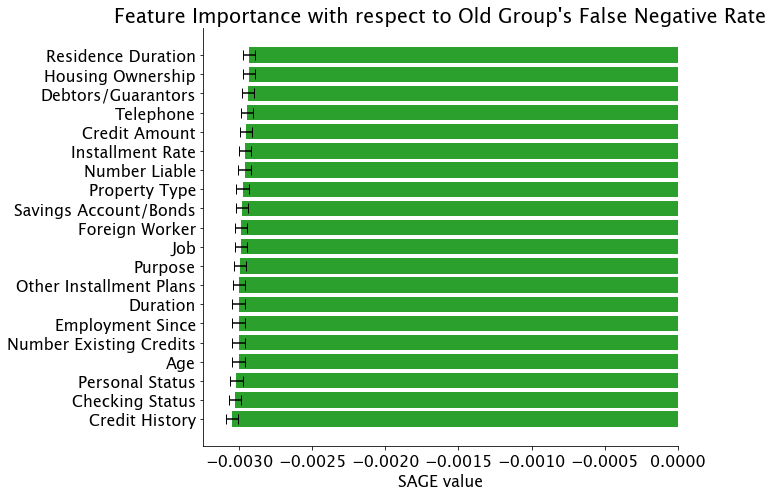

In [19]:
sage_values_old_fnr.plot(feature_names, title='Feature Importance with respect to Old Group\'s False Negative Rate')